In [1]:
# !rm -rf data
# !tar -xf data.tar

In [2]:
import torch
import torch.nn as nn
from torch.nn import Linear, ReLU, LeakyReLU, MSELoss, L1Loss, Sequential, Conv2d, ConvTranspose2d, MaxPool2d, MaxUnpool2d, AdaptiveAvgPool2d, Module, BatchNorm2d, Sigmoid, Dropout
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
import torchvision
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda")
print(device, torch.cuda.is_available())


cuda True


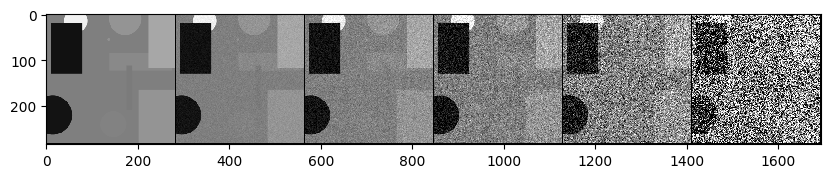

In [44]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
    def __call__(self, tensor):
        return torch.clamp(tensor + torch.randn(tensor.size()) * self.std + self.mean, 0, 1)
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
class MyDataset(datasets.VisionDataset):
    def __init__(self, N, transform, noise_transforms):
        self.transform = transform
        self.N = N
        self.noise_transforms = noise_transforms

    def __getitem__(self, index):
        img1 = Image.open("data/clean/clean" + str(index) + ".png")
#         img2 = Image.open("data/noisy/noisy" + str(index) + ".png")
        img1 = self.transform(img1)
        noisy = [nt(img1) for nt in self.noise_transforms]
#         img2 = self.noise_transform(img1)
#         img2 = self.transform(img2)
        return img1, noisy
    
    def __len__(self):
        return self.N

batch_size = 16
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])
noise_transforms = [AddGaussianNoise(0, x) for x in [.02, .05, .10, .20, .50]] 
dataset = MyDataset(5000, transform, noise_transforms)
train_set, validation_set = torch.utils.data.random_split(dataset, [0.9, 0.1])
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True, pin_memory=True)

batch1, batch2 = next(iter(train_loader))
img1 = batch1[0]
noisy = [b[0] for b in batch2]

grid = torchvision.utils.make_grid([img1] + noisy)
plt.imshow(transforms.ToPILImage()(grid), interpolation="none")
plt.show()

In [45]:
class NoiseRemoval(nn.Module):
    def __init__(self, width, height):
        super().__init__()
        self.conv1 = Conv2d(1, 16, 7, padding=4)
        self.bn1 = BatchNorm2d(16)
        self.conv2 = Conv2d(16, 32, 5, padding=3)
        self.bn2 = BatchNorm2d(32)
        self.conv3 = Conv2d(32, 128, 5, padding=3)
        self.bn3 = BatchNorm2d(128)
        self.pool = MaxPool2d(2, 2, return_indices=True)
        self.deconv3 = ConvTranspose2d(128, 32, 5, padding=3)
        self.deconv2 = ConvTranspose2d(32, 16, 5, padding=3)
        self.deconv1 = ConvTranspose2d(16, 1, 7, padding=4)
        self.deconv0 = ConvTranspose2d(1, 1, 1)
        self.unpool = MaxUnpool2d(2, 2)
        self.width = width
        self.height = height

    def forward(self, imgin):
        x = F.relu(self.conv1(imgin))
        size1 = x.size()
        x, ind1 = self.pool(x)
        x = F.relu(self.conv2(x))
        size2 = x.size()
        x, ind2 = self.pool(x)
        x = F.relu(self.conv3(x))
        
        x = F.relu(self.deconv3(x))
        x = self.unpool(x, ind2, size2)
        x = F.relu(self.deconv2(x))
        x = self.unpool(x, ind1, size1)
        x = self.deconv1(x)
        # x = self.deconv0(x)
        
        # if x is denoised image, return x
        # if x is noise, subtract it from input
        x = torch.clamp(imgin - x, 0, 1)
        return x

model = NoiseRemoval(280, 280).to(device)


[1] loss: 0.013968
valid loss: 0.006591
sample losses: 0.006477


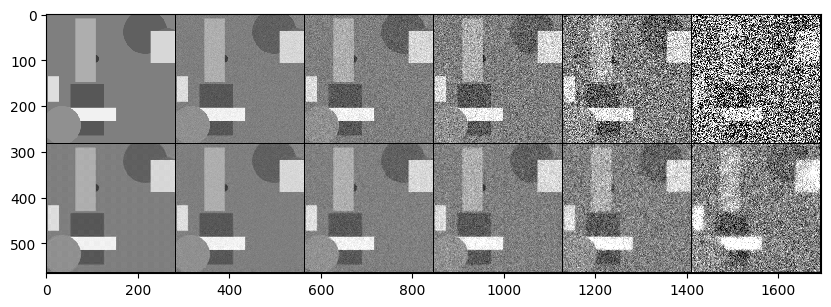

[2] loss: 0.006107
valid loss: 0.004328
sample losses: 0.004271


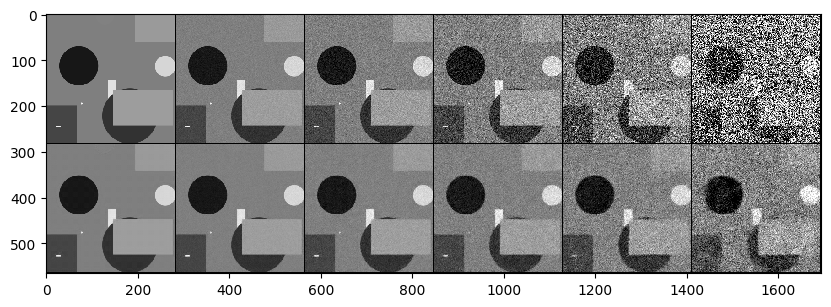

[3] loss: 0.004923
valid loss: 0.003972
sample losses: 0.004012


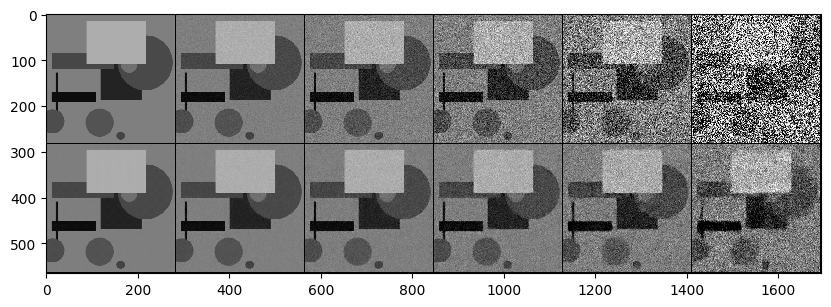

[4] loss: 0.004455
valid loss: 0.003536
sample losses: 0.003567


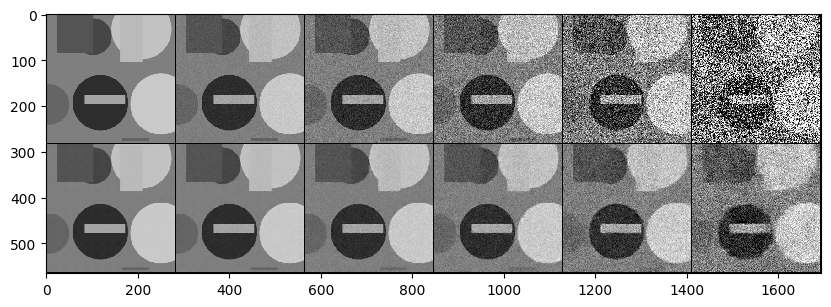

[5] loss: 0.004020
valid loss: 0.003234
sample losses: 0.003226


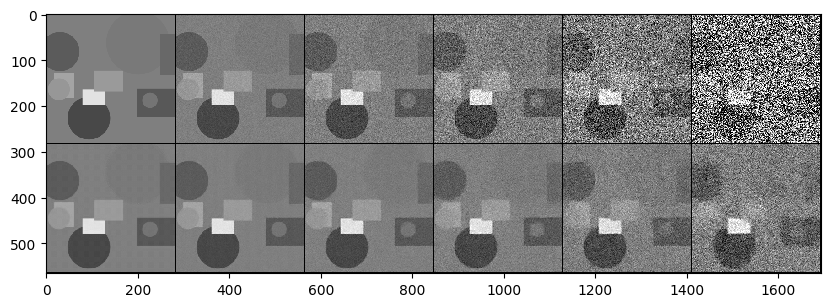

[6] loss: 0.003780
valid loss: 0.003082
sample losses: 0.003036


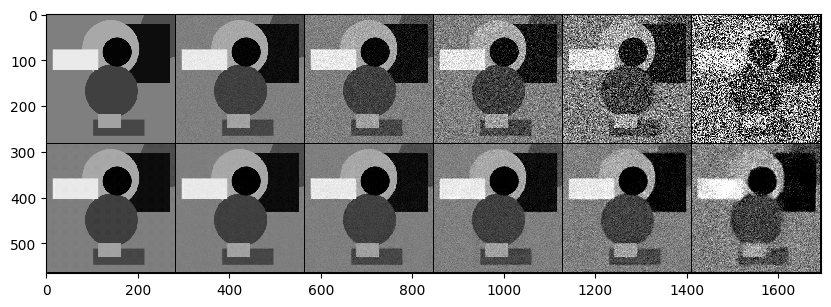

[7] loss: 0.003953
valid loss: 0.003085
sample losses: 0.003076


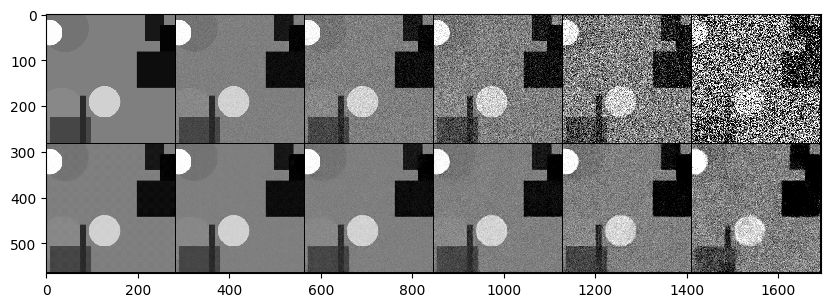

[8] loss: 0.004682
valid loss: 0.005754
sample losses: 0.005747


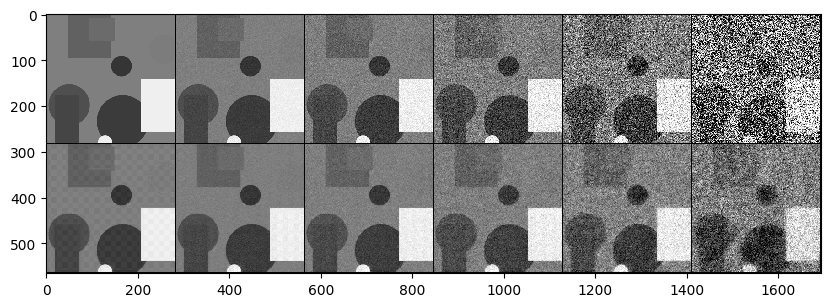

[9] loss: 0.005691
valid loss: 0.004331
sample losses: 0.004486


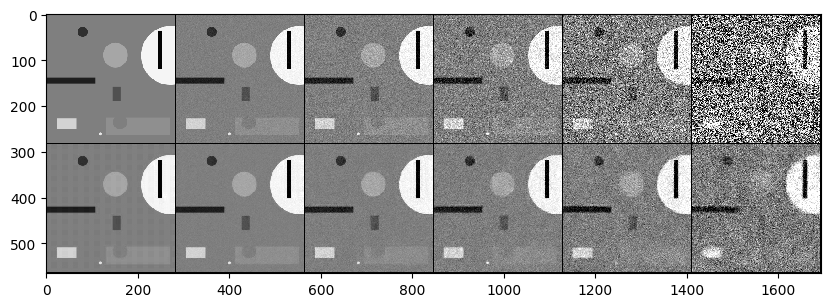

[10] loss: 0.004877
valid loss: 0.003873
sample losses: 0.003997


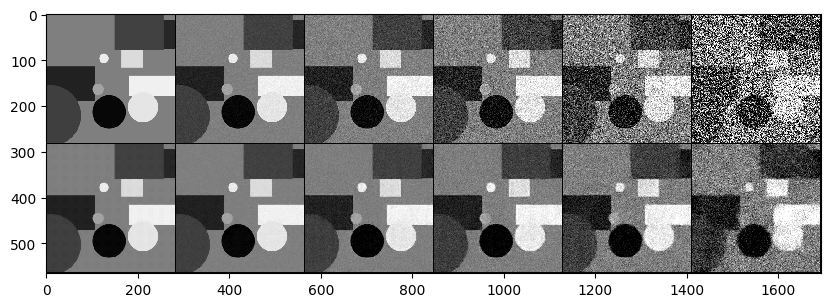

[11] loss: 0.004506
valid loss: 0.003629
sample losses: 0.003748


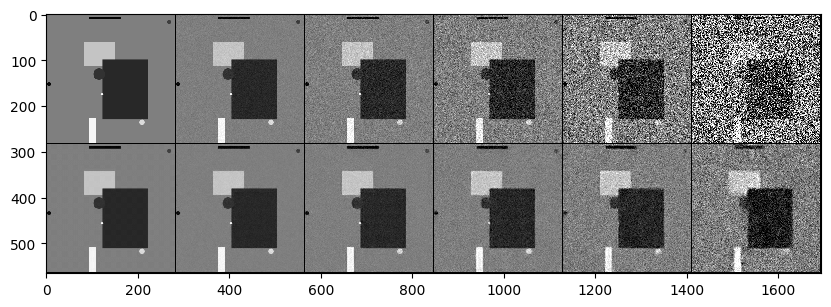

[12] loss: 0.004386
valid loss: 0.003416
sample losses: 0.003356


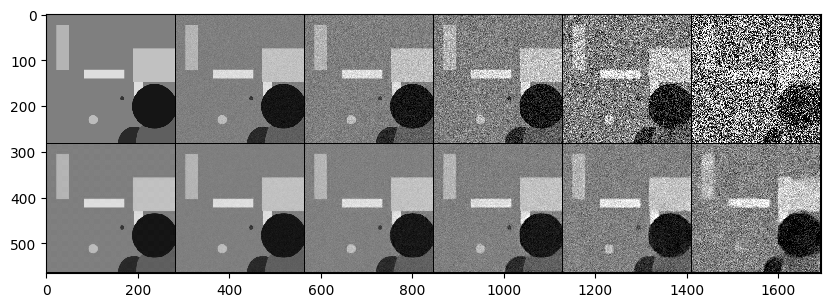

[13] loss: 0.003923
valid loss: 0.003101
sample losses: 0.003110


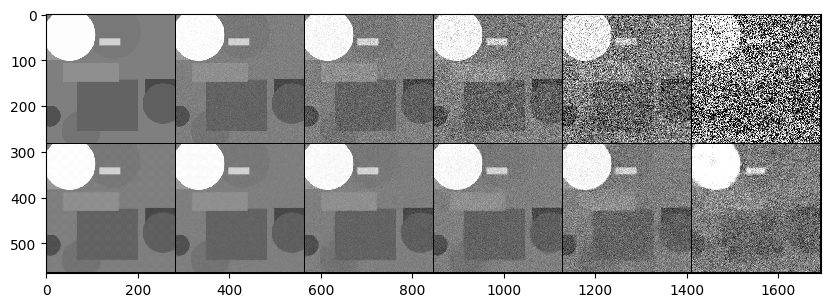

[14] loss: 0.003749
valid loss: 0.003038
sample losses: 0.003000


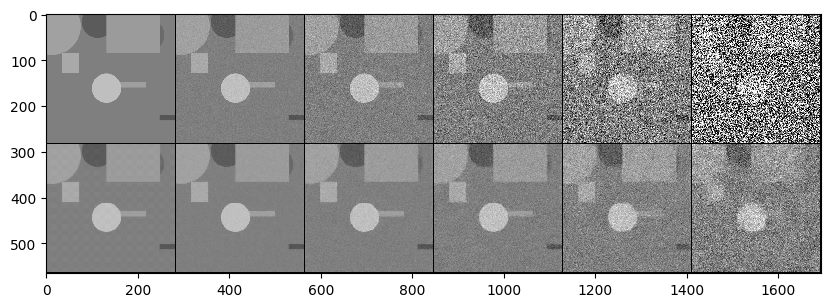

KeyboardInterrupt: 

In [46]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(10000):
    running_loss = 0.0
    batches = 0
    sample_noisy, sample_denoised = None, None
    sample_clean, sample_denoised_clean = None, None
    for i, data in enumerate(train_loader, 0):
        clear, noisy = data
        num_variations = len(noisy)
        noisy = torch.cat(noisy)
        
        clear = clear.to(device)
        noisy = noisy.to(device)
        
        X = noisy
        y = clear.repeat(num_variations, 1, 1, 1)
        optimizer.zero_grad()
        ypred = model(X)
        loss = criterion(y, ypred)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        batches += 1

        sample_noisy = noisy[-1]
        sample_denoised = ypred[-1]
    running_loss_valid = 0.0
    batches_valid = 0
    #sample_clean_valid, sample_denoised_clean_valid, sample_noisy_valid, sample_denoised_valid = None, None, None, None
    sample_inputs, sample_outputs = [], []
    sample_loss = 0
    denoise_n2, denoise_n3 = None, None
    for i, data in enumerate(validation_loader, 0):
        clear, noisy = data
        num_variations = len(noisy)
        noisy = torch.cat(noisy)
        
        clear = clear.to(device)
        noisy = noisy.to(device)
        
        X = torch.cat((clear, noisy))
        y = clear.repeat(num_variations + 1, 1, 1, 1)
        ypred = model(X)
        loss = criterion(y, ypred)
        running_loss_valid += loss.item()
        batches_valid += 1

#         sample_clean_valid = clear[-1]
#         sample_denoised_clean_valid = ypred[-1 + len(clear)]
#         sample_noisy_valid = noisy[-1]
#         sample_denoised_valid = ypred[-1]
        bs = clear.shape[0]
        sample_inputs = [clear[0]] + [noisy[bs*i] for i in range(num_variations)]
        sample_outputs = [ypred[bs*i] for i in range(num_variations+1)]
        sample_loss = loss.item()
    # print(f'ref_loss: {criterion(sample_noisy, sample_clean).item()}')
#     denoise_n2 = model(sample_denoised_valid.unsqueeze(0))[0]
#     denoise_n3 = model(denoise_n2.unsqueeze(0))[0]
#     sample_loss_2 = criterion(sample_clean_valid, denoise_n2).item()
#     sample_loss_3 = criterion(sample_clean_valid, denoise_n3).item()
    print(f'[{epoch + 1}] loss: {running_loss / batches:.6f}')
    print(f'valid loss: {running_loss_valid / batches_valid:.6f}')
    print(f'sample losses: {sample_loss:.6f}') #{sample_loss_2:.6f}')# {sample_loss_3:.6f}')
#     plt.rcParams['figure.figsize'] = [10, 5]
#     grid = torchvision.utils.make_grid([sample_noisy_valid, sample_denoised_valid, sample_clean_valid, sample_denoised_clean_valid])
    grid = torchvision.utils.make_grid(sample_inputs + sample_outputs, nrow=len(sample_inputs))
    plt.imshow(transforms.ToPILImage()(grid), interpolation="none")
    plt.show()

torch.Size([1, 1, 280, 280]) torch.Size([1, 1, 280, 280])
Sample Losses: 0.012694 0.002911 0.001978 0.001723 0.001700 


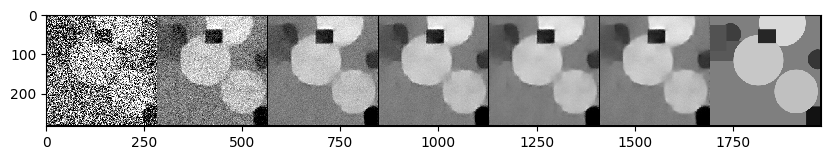

In [50]:
clear, noisy = next(iter(validation_loader))
num_variations = len(noisy)
noisy = noisy[-1] # noisiest batch of images

X = AddGaussianNoise(0, .5)(clear[-1]).unsqueeze(0) # noisy[-1].unsqueeze(0)
y = clear[-1].unsqueeze(0)
X, y = X.to(device), y.to(device)
samples = [X[0]]
sample_losses = []
print(X.shape, y.shape)
for i in range(5):
    ypred = model(X)
    loss = criterion(y, ypred)
    samples.append(ypred[0])
    sample_losses.append(loss.item())
    X = ypred
samples.append(clear[-1].to(device))

print('Sample Losses: ', end='')
for l in sample_losses:
    print(f'{l:.6f}', end=' ')
print()
grid = torchvision.utils.make_grid(samples)
plt.rcParams['figure.figsize'] = [10, 5]
plt.imshow(transforms.ToPILImage()(grid), interpolation='none')
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model.pth')